Imports

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

from matplotlib import rcParams as rc
#rc['figure.figsize'] = 10, 7
#rc['axes.labelsize'] = 16
#rc['axes.titlesize'] = 20
#rc['legend.fontsize'] = 16

from astropy import constants as cst
import math as mt
from scipy.special import gamma
from matplotlib import cm as cmap
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from astropy import constants as cst
#from tqdm import tqdm_notebook
import tqdm

Define Constants

In [81]:
# Constants in cgs units
c = cst.c.cgs.value                     # Speed of light (cm/s)
m_e = cst.m_e.cgs.value                 # Electron mass (g)
e = cst.e.esu.value                     # Elementary charge (esu)
M_sun = cst.M_sun.cgs.value             # Sun's mass (g)
G = cst.G.cgs.value                     # Gravitational constant (erg cm / g^2)
h = cst.h.cgs.value                     # Planck's constant in Erg Second
sigma_t = cst.sigma_T.cgs.value         # Thomson scattering cross-section


# Derived constants
M = 4e6 * M_sun                         # Sgr A*'s mass
Lj = 9e37                               # Accretion power (erg/s) (derived in the notes)
r_g = G * M / c**2                      # Gravitational radius
r_i = 10 * r_g                          # Initial radius (cm)
#r_f = 1000 * r_g                        # Final radius (cm)
r_f = 100 * r_g
dz_i = 0.05 * r_i                       # Height of first slice
theta = mt.radians(10)                  # opening angle of 10 degrees converted to radians
vel = 0.3 * c                           # Bulk velocity (cm/s)
dist = 2.5e22                              # Distance from Sgr A* (cm)
p = 2                                   # Electron power law degree
pitch = np.pi/2                         # pitch angle in radians
eta = 1e-7                              # radiative efficiency
beta_plasma = 1                         # Plasma beta
#beta = 1


#ranges:
eta_values = np.linspace(0.1, 1.5, 5)           # a range of efficiencies over which to measure
r_values_0 = np.logspace(np.log10(r_i), np.log10(r_f), 501)     # a range of 500 radial values  
dr_values = np.ediff1d(r_values_0)              # the step size between each pair of r values
r_values = r_values_0[:-1]                      # redefining r_values such that it has the same length as dr_values
nu_values = np.logspace(7, 14, 500)             # a range of 500 frequencies
E_e = np.logspace(0, 3, 500) * m_e * c**2       # a range of 500 electron energies 
omega = 2*np.pi*nu_values                       # angular frequency 
lorentz_range = np.linspace(1, 1000, 500)       # range of 500 Lorenz factors
dr_0 = dr_values[0]                             # defining the first step width

Define Functions

In [82]:
def B_field(r, dr, Lj, v = vel):
    """
    This function calculates the magnetic field for a given bulk velocity and accretion power over a range of radius

    parameters
    ---------
    r: np.ndarray
        array of radii of the expanding jet
    dr: np.ndarray
        array of all radial steps taken during the integration over radial distance
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet

    returns
    ----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii
    """

    return (1 / r) * np.sqrt((4 * Lj) / v) * (dr_0 / dr)

def Constant(r, Lj = Lj, v = vel, beta_plasma = beta_plasma):
    """
    This function calculates the constant C in the definition of the absorption coefficient
    for each radial value.

    parameters
    -----------
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure

    returns
    ---------
    C: np.ndarray
        array of constants appertaining to each radius
    """

    return (Lj / ((1 + beta_plasma) * (3 * np.pi * np.log(10) * v)) * r**(-2))


def absorption(nu, r, dr, Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the absorption co-efficient at the given frequency.
    The equation used can be found in 6.53 R&L.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    alpha_nu: np.ndarray
        array of absorption co-efficients at time t for the given range of frequencies
    """
    C = Constant(r, Lj, v, beta_plasma)
    B = B_field(r, dr, Lj, v)

    comp_1 = (np.sqrt(3) * e**3) / (8 * np.pi * m_e)
    comp_2 = np.power((3 * e)/(2 * np.pi * m_e**3 * c**5), p / 2)
    comp_3 = C * np.power(B * np.sin(pitch), (p + 2) / 2)
    comp_4 = mt.gamma((3 * p + 2) / 12) * mt.gamma((3 * p + 22) / 12)
    comp_5 = np.power(nu, -(p + 4) / 2)

    alpha_nu = comp_1 * comp_2 * comp_3 * comp_4 * comp_5
    return alpha_nu

def optical_depth(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the optical depth of the jet at each frequency nu
    over a range of radii r.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    tau: np.ndarray
        an array of optical depths appertaining to each frequency nu and 
        radius r
    """
    
    return absorption(nu, r, dr, Lj, v, beta_plasma, p) * r

def power_syn(r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the total power per unit volume per unit frequency.
    The equation can be found in 6.36 R&L.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    power_nu: np.ndarray
        total power per unit volume per unit frequency evaluated at each time step t.
    """
    C = Constant(r, Lj, v, beta_plasma)
    B = B_field(r, dr, Lj, v)

    comp_1 = (np.sqrt(3) * e**3 * C * B * np.sin(pitch)) / (2 * np.pi * m_e * c**2 * (p + 1))
    comp_2 = mt.gamma(p / 4 + 19 / 12) * mt.gamma(p / 4 - 1 / 12)
    comp_3 = np.power((m_e * c * omega) / (3 * e * B * np.sin(pitch)), - (p - 1) / 2)
    power_omega = comp_1 * comp_2 * comp_3      #total power per unit volume per angular frequency
    power_nu = 2 * np.pi * power_omega          #total power per unit volume per unit frequency
    return power_nu 

def source_syn(nu, r, dr, Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the source function of the jet at each radial value
    and frequency.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    S_nu: np.ndarray
        source function at each radius and frequency.
    """

    P_nu = power_syn(r, dr, Lj, v, beta_plasma, p)
    alpha_nu = absorption(nu, r, dr, Lj, v, beta_plasma, p)
    S_nu = P_nu / (4 * np.pi * alpha_nu)
    return S_nu

def I_syn(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):
    """
    This function calculates the synchrotron intensity of the jet at each
    radius r and frequency nu.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    I: np.ndarray
        intensity at each radius and frequency.
    """
    S_nu = source_syn(nu, r, dr, Lj, v, beta_plasma, p)
    tau = optical_depth(nu, r, dr, Lj, v, beta_plasma, p)
    I_nu = S_nu * (1 - np.exp(-tau))
    return I_nu

def flux_syn(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2, d=dist):
    """
    This function calculates the flux of lobes at earth in mJy.

    Parameters:
    -----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -----------
    F_nu : np.ndarray  
        an array of fluxes for each radius and frequency
    """
    
    I_nu = I_syn(nu, r, dr, Lj, v, beta_plasma, p)
    F_nu = (I_nu * r * dr) / (np.tan(theta / 2) * 4 * np.pi * d**2)
    return  F_nu


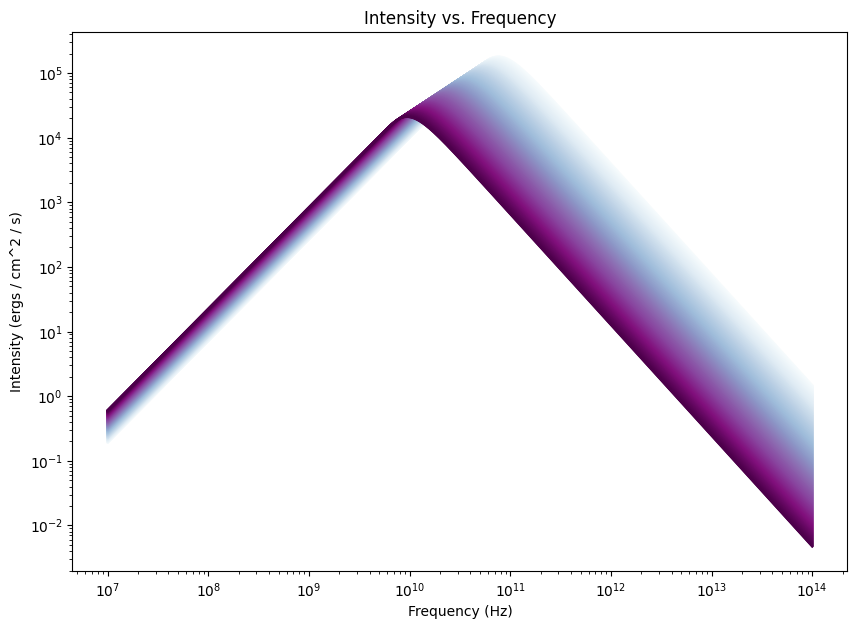

In [83]:
cmap = cm.BuPu

fig_I_nu = plt.figure(figsize=(10,7))
for i, r in enumerate(r_values):
    color = cmap(float(i) / len(r_values))
    plt.loglog(nu_values, I_syn(nu_values, r, dr_values) / (h * nu_values), color = color)
plt.title('Intensity vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity (ergs / cm^2 / s)')
plt.show()


# Obtaining a photon distribution
The first step to be able to use the Monte Carlo tutorial is to obtain a probability distribution function (PDF) for the photons in the jet. Using the code that calculated the flux, we will do so in the following steps:

1. Plot the intensity of the first slice
    * The intensity of each slice is already calculated in the code we wrote for the flat jet spectrum. We use that value, making sure we only plot the intensity of the first slice.
2. Move from the intensity to a unit with number of photons
3. Normalise
    * Now we need to normalise the area under the curve, this is done by dividing the number of photons array, by the area under the graph.
4. Sample the distribution

In [84]:
def photon_dist(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p = p):
    """
    This function calculates the distribution of photons
    over a range of frequencies and radii.

    Parameters
    ----------
    nu: np.ndarray
        an array of frequencies over which to calculate
    r: np.ndarray
        array of radial values around the jet
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure
    p: int
        the power of the electron distribution

    Returns
    -------
    photon_dist: np.ndarray
        un-normalized photon distribution.
    """

    I_nu = I_syn(nu, r, dr, Lj, v, beta_plasma, p)

    # We need #/s for our photon distribution. To obtain this we calculate
    # I_nu * (1/h*nu) * nu * Area * 4pi 
    photon_dist = I_nu * (h * r * dr * 4 * np.pi) 
    #photon_dist = I_nu / (h * nu_values) 

    return photon_dist

def photon_pdf(nu, r, dr, Lj=Lj, v=vel, beta_plasma=beta_plasma, p=2):

    photons = photon_dist(nu, r, dr, Lj, v, beta_plasma, p)
    return photons / np.sum(photons)

def sample_photons(mc_parms = None, number = 1000, p = p, nu = nu_values, Lj = Lj, v = vel, beta_plasma=beta_plasma):
    """
    This function samples a previously obtained, normalised photon distribution.

    Parameters
    ----------
    mc_parms: dict
        a dictionary containing a number of values relevant to the mc sampling
        code and parametrizing the jet at each radial step
    number : int
        the number of photons to be sampled
    nu: np.ndarray
        an array of frequencies over which to calculate
    Lj: float
        accretion power [erg/s] (derived in the notes)
    v: float
        bulk velocity of the jet
    beta_plasma: float
        the ratio of the plasma pressure within the jet to the magnetic field
        pressure

    Returns
    -------
    v_inv: ndarray
        Sampled photon distribution.
    """
    r = mc_parms['r_range']
    dr = mc_parms['dr_range']
    photons = photon_dist(nu, r, dr, Lj, v, beta_plasma, p)
    photon_pdf = photons / np.sum(photons)

    photon_cdf = np.cumsum(photon_pdf)
    u = np.random.uniform(0, 1, size = number)
    v_inv = np.interp(u, photon_cdf, nu)

    return v_inv

<Figure size 1000x700 with 0 Axes>

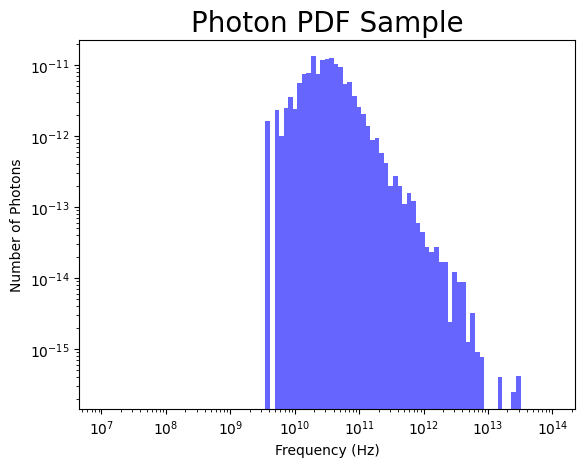

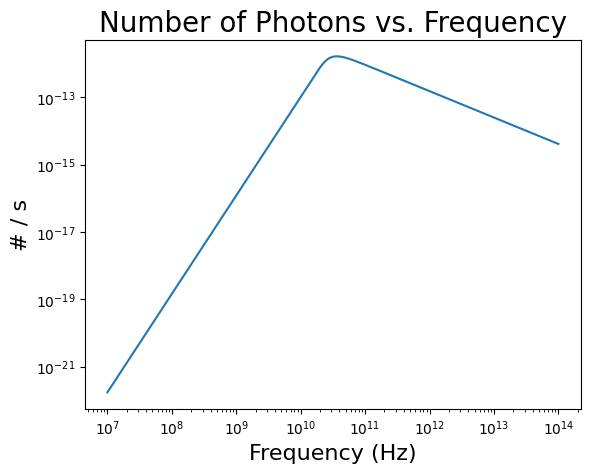

In [85]:
fig1 = plt.figure(figsize=(10, 7))
N_phot = photon_dist(nu_values, r_values, dr_values)

mc_parms={'n_photons':int(1e6),             # produce 100000 photons
            'kt_seeds':1.6e12,              # 1 keV input photons
            'H': r_values[0],               # H ~ R, and R ~ 100 R_g ~ 3e7 cm
            'velocity': vel,                # bulk velocity
            #'v_dist': sample_electrons,     # name of electron distribution function
            'hnu_dist': sample_photons,     # name of photon distribution function
            'r_range': r_values,
            'dr_range': dr_values,
            'tau': 1,                       
            }

photon_samples = sample_photons(mc_parms)
fig_photon_pdf = plt.figure()
plt.hist(photon_samples, bins= np.logspace(7, 14, 100), density=True, alpha=0.6, color='b', log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Number of Photons')
plt.title('Photon PDF Sample', fontsize=20)
plt.show()

plt.semilogx(nu_values, N_phot)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.title('Number of Photons vs. Frequency', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('# / s', fontsize=16)

plt.show()

# Obtaining an electron distribution

C:\Users\Ruth\AppData\Roaming\Python\Python312\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Ruth\AppData\Roaming\Python\Python312\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


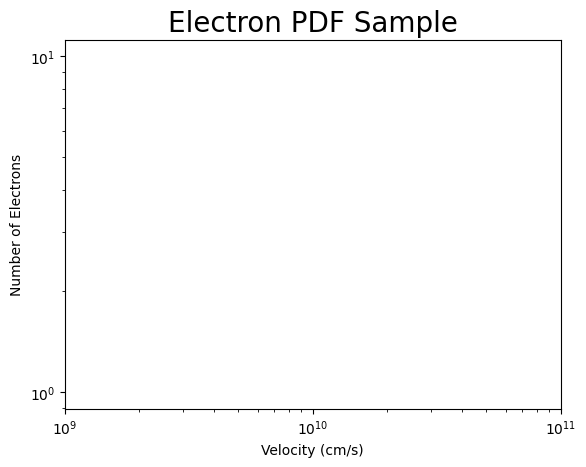

In [86]:
def electron_dist(r, gamma_e):
    """
    This function calculates the distribution of electrons
    over a range of lorentz factors and radii.

    Parameters
    ----------
    r: np.ndarray
        array of radial values around the jet
    gamma_e: np.ndarray
        array of lorentz factors over which to calculate

    Returns
    -------
    electron_d: np.ndarray
        un-normalized electron distribution.
    
    """
    C = Constant(r)
    electron_d = C * gamma_e **(-p)
    
    return electron_d


def sample_electrons(mc_parms = None, lorentz_range = lorentz_range):
    """
    This function samples a the normalised electron distribution and converts 
    the output electrons into velocities.

    Parameters
    ----------
    mc_parms: dict
        a dictionary containing a number of values relevant to the mc sampling
        code and parametrizing the jet at each radial step
    lorentz_range: np.ndarray  
        an array of lorentz factors over which to calculate
    
    Returns
    -------
    v_inv: ndarray
        Sampled electron distribution.
    """

    """r = mc_parms['r_range']
    dr = mc_parms['dr_range']
    
    electrons_pdf_norm = electron_dist(r, lorentz_range) / np.sum(electron_dist(r, lorentz_range))
    electron_cdf = np.cumsum(electrons_pdf_norm)

    u = np.random.uniform(0, 1, size = 10000)
    gamma = np.interp(u, electron_cdf, lorentz_range)
    ##### go from gamma to c
    v_final = c * np.sqrt(1-1/(gamma**2))

    return v_final"""

    r = mc_parms['r_range']
    dr = mc_parms['dr_range']
    
    electrons_pdf_norm = electron_dist(r, lorentz_range) / np.sum(electron_dist(r, lorentz_range))
    electron_cdf = np.cumsum(electrons_pdf_norm)

    u = np.random.uniform(0, 1, size = 1)
    gamma = np.interp(u, electron_cdf, lorentz_range)
    ##### go from gamma to c
    v_final = c * np.sqrt(1-1/(gamma**2))

    return v_final


mc_parms={'n_photons':int(1e6),             # produce 100000 photons
            'kt_seeds':1.6e12,              # 1 keV input photons
            'H': r_values[0],               # H ~ R, and R ~ 100 R_g ~ 3e7 cm
            'velocity': vel,                # bulk velocity
            'v_dist': sample_electrons,     # name of electron distribution function
            'hnu_dist': sample_photons,     # name of photon distribution function
            'r_range': r_values,
            'dr_range': dr_values,
            'tau': 1,                       
            }

electron_sample = sample_electrons(mc_parms)
plt.hist(electron_sample, bins= np.logspace(7, 14, 100), density=True, alpha=0.6, color='b', log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e9, 1e11)
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Number of Electrons')
plt.title('Electron PDF Sample', fontsize=20)
plt.show()


# Monte Carlo simulation
Now, having written the electron and photon sampling functions we are able to feed it back to our MC simulation.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad

c_light=3.e10              
m_electron=9.10938356e-28  
sigma_t=6.65e-25           
figure_counter=0           

def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance = tau / sigma_t / electron_density   
     
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v = mc_parms['v_dist'](mc_parms)
    n = draw_electron_direction(v,p_photon)
    return(v*n)


def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light, np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))


def mu_of_p_electron(beta,p):
    mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    return(mu)

def lorentz_transform(p,v):
    beta = np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds = np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds'] 
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    fig.savefig(filename)
    figure_counter += 1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)


In [ ]:
print(hist_plot)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Ruth\AppData\Local\Temp\ipykernel_12580\1034967043.py:89: RuntimeWarning: divide by zero encountered in divide
  mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
C:\Users\Ruth\AppData\Local\Temp\ipykernel_12580\1034967043.py:89: RuntimeWarning: invalid value encountered in subtract
  mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
C:\Users\Ruth\AppData\Local\Temp\ipykernel_12580\1034967043.py:164: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


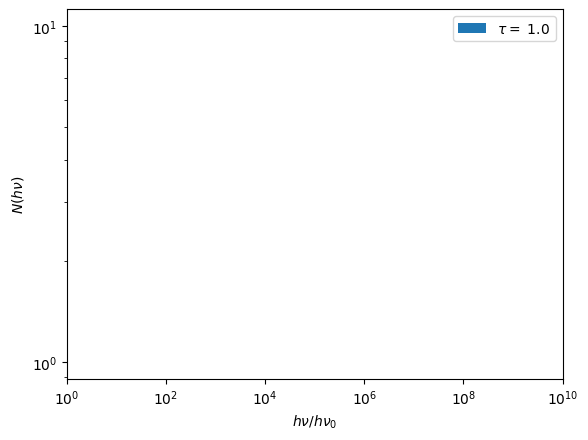

Fraction of escaping photons: 1.670e-01

Compton y parameter: 2.635e+02

This is scattered
16704
[1.33056153e+11 2.43080109e+11 8.23551566e+12 ... 1.09509374e+11
 1.75892971e+11 2.84926005e+12]
This is seeds
16704
[1.33056153e+11 2.43080109e+11 8.23551566e+12 ... 1.09509374e+11
 1.75892971e+11 2.84926005e+12]


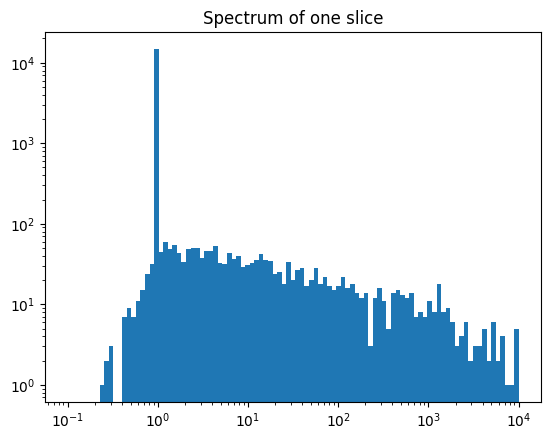

[1.33056153e+11 2.43080109e+11 8.23551566e+12 ... 1.09509374e+11
 1.75892971e+11 2.84926005e+12]
[1.33056153e+11 2.43080109e+11 8.23551566e+12 ... 1.09509374e+11
 1.75892971e+11 2.84926005e+12]


In [99]:
results = []
#seed_binned = []
#scattered_binned = []

scattered_list = []
seeds_list = []
hist_plot = np.zeros(100)

def total_mc(r_values):
    for i in tqdm.notebook.tqdm(range(len(r_values))):
        r = r_values[i]
        dr = dr_values[i]

        mc_parms={'n_photons':int(1e5),         # start somewhat small and go up
            'kt_seeds':1.6e12,                  # 1 keV input photons
            'H': r_values[0],                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
            'velocity': 3e10 * 0.3,             # 10% speed of light--pretty hot
            'v_dist': sample_electrons,         # name of velocity distribution function
            'gamma_min': 0,
            'gamma_max': 3,                     # range for electron gamma 1e0 to 1e3
            'hnu_dist': sample_photons,         # name of photon distribution function
            'r_range': r,
            'dr_range': dr,
            'tau': 1,                           # tau ~ 0.1: Small-ish optical depth # t=1 for photosphere
            }
        
        hnu_scattered, hnu_seeds = plot_mc(mc_parms, bins = nu_values, xlims=[1, 1e10])
        #results.append((hnu_scattered, hnu_seeds))
        scattered = hnu_scattered * mc_parms['kt_seeds']
        seeds = hnu_seeds * mc_parms['kt_seeds']
        

        #hist = np.histogram(scattered, bins = np.logspace(-1, 4, 100))
        #hist_2 = np.histogram(scattered/seeds, bins = np.logspace(-1, 4, 100))
        
        print("This is scattered")
        print(len(scattered))
        print(scattered)

        print("This is seeds")
        print(len(seeds))
        print(scattered)

        ######### Now we have the results of scattered and seeds from the fist slice
        # I want to add them to a list that will "collect" the results as we go
        # From this point onwards this function is not complete
        scattered_list =+ scattered
        seeds_list =+ seeds

        

        #print('size', len(hist), len(hist_plot), len(hnu_scattered), len(scattered))
        #print("This is hist")
        #print(hist)
        #hist_plot[:1] += hist
        #print("This is hist_plot")
        #print(hist_plot)
        
    
        plt.hist(scattered/seeds, bins = np.logspace(-1, 4, 100))
        plt.xscale('log')
        plt.yscale('log')
        plt.title("Spectrum of one slice")
        plt.show()
        print(scattered_list)
        print(seeds_list)
        #b.append(seed)

        #cast both arrays to a histogram (in the loop)
        #scattered_hist = np.histogram(scattered, bins = np.logspace(-1, 4, 100))
        

    return scattered_list, seeds_list
res = total_mc(r_values[:1])

In [100]:
print(scattered_list)

[]


In [ ]:
res[1]

array([1.00000000e-01, 1.12332403e-01, 1.26185688e-01, 1.41747416e-01,
       1.59228279e-01, 1.78864953e-01, 2.00923300e-01, 2.25701972e-01,
       2.53536449e-01, 2.84803587e-01, 3.19926714e-01, 3.59381366e-01,
       4.03701726e-01, 4.53487851e-01, 5.09413801e-01, 5.72236766e-01,
       6.42807312e-01, 7.22080902e-01, 8.11130831e-01, 9.11162756e-01,
       1.02353102e+00, 1.14975700e+00, 1.29154967e+00, 1.45082878e+00,
       1.62975083e+00, 1.83073828e+00, 2.05651231e+00, 2.31012970e+00,
       2.59502421e+00, 2.91505306e+00, 3.27454916e+00, 3.67837977e+00,
       4.13201240e+00, 4.64158883e+00, 5.21400829e+00, 5.85702082e+00,
       6.57933225e+00, 7.39072203e+00, 8.30217568e+00, 9.32603347e+00,
       1.04761575e+01, 1.17681195e+01, 1.32194115e+01, 1.48496826e+01,
       1.66810054e+01, 1.87381742e+01, 2.10490414e+01, 2.36448941e+01,
       2.65608778e+01, 2.98364724e+01, 3.35160265e+01, 3.76493581e+01,
       4.22924287e+01, 4.75081016e+01, 5.33669923e+01, 5.99484250e+01,
      

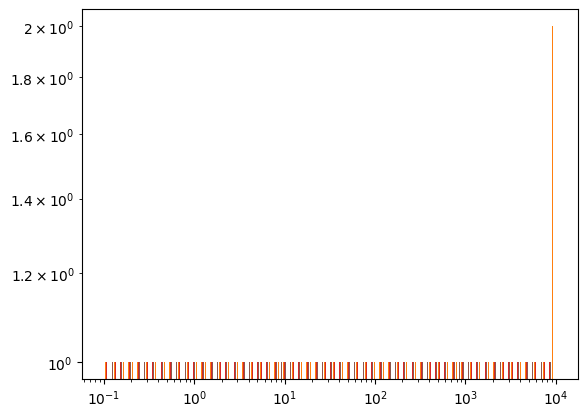

In [ ]:
#print(res)
plt.hist(res/ bins = np.logspace(-1, 4, 100))
plt.xscale('log')
plt.yscale('log')